In [1]:
%load_ext autoreload
%autoreload 2

# Janus decoder reconstruction

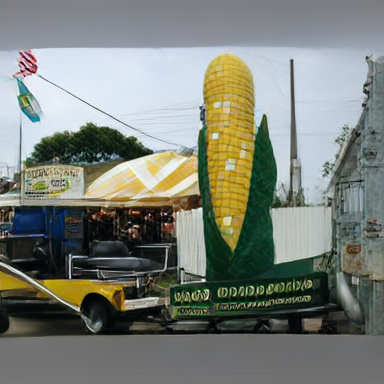

In [48]:
import os
import torch
import torchvision.transforms as pth_transforms
from PIL import Image
from omegaconf import OmegaConf
from model.decoder import get_decoder
from janus.models import MultiModalityCausalLM, VLChatProcessor


model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"

janus = MultiModalityCausalLM.from_pretrained(model_path, trust_remote_code=True)
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)

exp_path = "/data1/jjc/experiment/bi_tok/0527_janus_decoder_1024_blip3odata"
config = OmegaConf.load(os.path.join(exp_path, "config.yaml"))
decoder = get_decoder(config.decoder)
ckpt = torch.load(os.path.join(exp_path, "Decoder-bi_tok-5k"), map_location="cpu")
decoder.load_state_dict(ckpt, strict=True)

decoder.eval()

img = Image.open("/data1/LargeData/ImageNet/val/n13133613/ILSVRC2012_val_00010376.JPEG")
pixel_values = vl_chat_processor.image_processor([img], return_tensors="pt").pixel_values
rec = decoder(janus.vision_model(pixel_values))
inversed_transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
])

rec = ((rec + 1) / 2).clamp(0, 1)
rec = inversed_transform(rec.squeeze(0))

rec

In [140]:
import torch
from omegaconf import OmegaConf
from janus.models import MultiModalityCausalLM, VLChatProcessor
from diffusers import DDIMScheduler
from torchvision import transforms as pth_transforms
from tqdm.auto import tqdm, trange
from janus.models.diff_mlp import SimpleMLPAdaLN
from model.decoder import get_decoder

model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"

janus = MultiModalityCausalLM.from_pretrained(model_path, trust_remote_code=True)
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

janus_ckpt = torch.load("/data1/jjc/experiment/bi_tok/0527_janus_gen_1024_journeydb/janus-bi_tok-120k", map_location="cpu")
janus.language_model.load_state_dict(janus_ckpt, strict=True)

config = OmegaConf.load("config/janus_gen.yaml")
decoder = get_decoder(config.decoder)
ckpt = torch.load("/data1/jjc/experiment/bi_tok/0527_janus_decoder_1024_blip3odata/Decoder-bi_tok-40k", map_location="cpu")
decoder.load_state_dict(ckpt, strict=True)

diff_head = SimpleMLPAdaLN(
    in_channels = 1024,
    model_channels = 1024,
    out_channels = 1024,
    z_channels = 2048,
    num_res_blocks = 2,
)
head_ckpt = torch.load("/data1/jjc/experiment/bi_tok/0527_janus_gen_1024_journeydb/diff_head-bi_tok-120k", map_location="cpu")
diff_head.load_state_dict(head_ckpt, strict=True)

device = "cuda:5"

diff_head = diff_head.to(device).eval()
janus = janus.to(device).eval()


sample_scheduler = DDIMScheduler(
    beta_schedule          = "scaled_linear",
    beta_start             = 0.00085,
    beta_end               = 0.012,
    num_train_timesteps    = 1000,
    clip_sample            = False,
    prediction_type        = "v_prediction",
    set_alpha_to_one       = True,
    steps_offset           = 1,
    trained_betas          = None,
    timestep_spacing       = "trailing",
    rescale_betas_zero_snr = True
)
inversed_transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
])

def diff_generate(feature, diff_head):
    sample_scheduler.set_timesteps(50)
    B = feature.shape[0]

    pred_latents = torch.randn((B, 1024), device=feature.device)
    pred_latents *= sample_scheduler.init_noise_sigma

    for t in sample_scheduler.timesteps:
        pred_latents = sample_scheduler.scale_model_input(pred_latents, t)
        with torch.no_grad():
            t_sample = torch.as_tensor([t], device=feature.device)
            noise_pred = diff_head(pred_latents, t_sample.repeat(B), feature)
            # noise_pred = noise_preds[:z.shape[0] // 2]
            # noise_pred_uncond = noise_preds[z.shape[0] // 2:]
            # noise_pred = noise_pred_uncond + cfg_scale * (noise_pred - noise_pred_uncond)
            pred_latents = sample_scheduler.step(noise_pred, t, pred_latents).prev_sample
    
    # print(pred_latents.shape)
    return pred_latents


In [176]:
prompt = "A man in a white shirt and black pants is playing guitar on the street, with a crowd of people watching him. The background is a city street with buildings and trees."
cfg_scale = 5

if cfg_scale > 1:
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)
    # input_ids = torch.cat([input_ids, 100002*torch.ones(150 - input_ids.shape[0], dtype=torch.long)], dim=0)
    input_ids = torch.cat([input_ids, torch.tensor([100003])]).to(device)
    input_ids = input_ids.unsqueeze(0)
    input_ids = input_ids.repeat(2, 1)
    input_ids[1, :-1] = 100002
    print(input_ids)
    
else:
    # input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = vl_chat_processor.tokenizer(prompt, return_tensors="pt").input_ids[0]
    input_ids = torch.LongTensor(input_ids)
    # input_ids = torch.cat([input_ids, 100002*torch.ones(150 - input_ids.shape[0], dtype=torch.long)], dim=0)
    input_ids = torch.cat([input_ids, torch.tensor([100003])]).to(device).unsqueeze(0)

tensor([[100000,     32,    668,    279,    245,   3682,  18868,    285,   3438,
          28114,    317,   6069,  14661,    331,    254,   8276,     11,    366,
            245,  11800,    280,   1245,   9697,    857,     13,    429,   4140,
            317,    245,   3787,   8276,    366,  12404,    285,   7636,     13,
         100003],
        [100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002,
         100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002,
         100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002,
         100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002, 100002,
         100003]], device='cuda:5')


In [177]:
inputs_embeds = janus.language_model.get_input_embeddings()(input_ids).to(device)
generated_tokens = torch.zeros((1, 576), dtype=torch.int).to(device)

print(inputs_embeds.shape)

torch.Size([2, 37, 2048])


In [178]:
generated_tokens = torch.zeros((1, 576, 1024)).to(device)

with torch.no_grad():
    for i in trange(576):
        outputs = janus.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        if cfg_scale > 1:
            cond_z = hidden_states[0, -1, :]
            uncond_z = hidden_states[1, -1, :]
            z = uncond_z + cfg_scale * (cond_z - uncond_z)
            z = z.unsqueeze(0)
        else:
            z = hidden_states[:, -1, :]
        next_token = diff_generate(z, diff_head)
        generated_tokens[:, i] = next_token.squeeze()
        img_embeds = janus.aligner(next_token.unsqueeze(0))
        
        if cfg_scale > 1:
            inputs_embeds = img_embeds.repeat(2, 1, 1)
        else:
            inputs_embeds = img_embeds

  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [00:51<00:00, 11.26it/s]


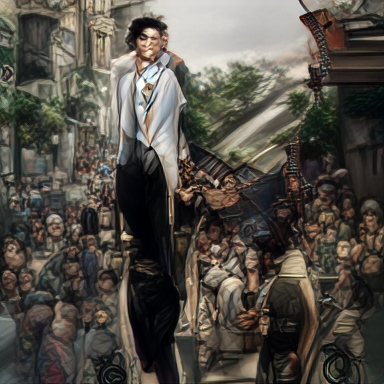

In [179]:
decoder = decoder.to(device).eval()
gen = decoder(generated_tokens)
gen = ((gen + 1) / 2).clamp(0, 1)
gen = inversed_transform(gen.squeeze(0))

gen

# teacher forcing

In [30]:
from util.dataloader import get_dataloader

dataloader = get_dataloader(config.data)
ids = iter(dataloader)

Setting num_proc from 128 to 55 for the train split as it only contains 55 shards.
Generating train split: 550000 examples [04:33, 2014.09 examples/s]


In [180]:
batch = next(ids)
# for batch in dataloader:
text = batch["texts"][2]
pixel_values = batch["pixel_values"][2].unsqueeze(0)
    # break

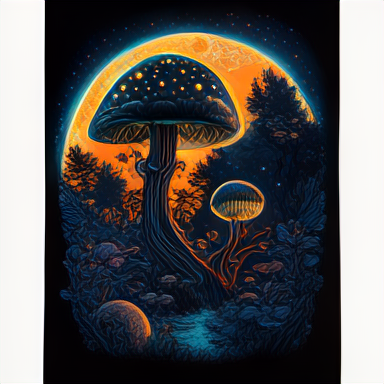

In [181]:
diff_head = diff_head.to(device).eval()
janus = janus.to(device).eval()

input_ids = torch.cat([text.to(device), torch.tensor([100003], device=device)])
text_embedding = janus.language_model.get_input_embeddings()(input_ids).unsqueeze(0).to(device)
# print(text_embedding.shape)

pixel_values = pixel_values.to(device)
img_features = janus.vision_model(pixel_values)
img_embedding = janus.aligner(img_features)

joint_embedding = torch.cat((text_embedding, img_embedding), dim=1)

hidden_states = janus.language_model(
    inputs_embeds=joint_embedding,
    attention_mask=None,
    output_hidden_states=True,
).hidden_states[-1]

z = hidden_states[:, -576-1:-1, :]

decoder = decoder.to(device).eval()
rec = decoder(img_features)
rec = ((rec + 1) / 2).clamp(0, 1)
rec = inversed_transform(rec.squeeze(0))

rec

In [182]:
generated_tokens = torch.zeros((1, 576, 1024)).to(device)

for i in trange(576):
    next_token = diff_generate(z[:, i, :], diff_head)
    # print(next_token.shape)
    generated_tokens[:, i] = next_token.squeeze()
    # break

  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [00:39<00:00, 14.52it/s]


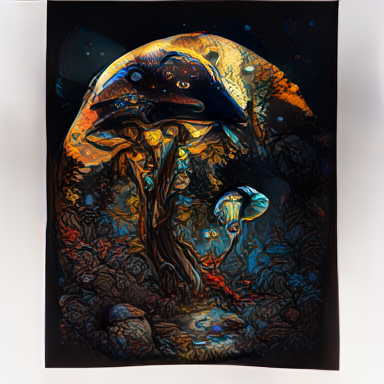

In [183]:
import torchvision.transforms as pth_transforms

decoder = decoder.to(device).eval()
inversed_transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
])

gen = decoder(generated_tokens)
gen = ((gen + 1) / 2).clamp(0, 1)
gen = inversed_transform(gen.squeeze(0))

gen

In [5]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

# conversation = [
#     {
#         "role": "<|User|>",
#         "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
#     },
#     {"role": "<|Assistant|>", "content": ""},
# ]

# sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
#     conversations=conversation,
#     sft_format=vl_chat_processor.sft_format,
#     system_prompt="",
# )
# prompt = sft_format + vl_chat_processor.image_start_tag

prompt = "The image depicts a train on a railway track, likely part of the State Railway of Thailand (SRT), as indicated by the logo and text on the front of the train. The train is painted in a vibrant orange and blue color scheme with white accents. It appears to be a passenger train, given its design and the presence of multiple windows along its side. The train is traveling under an elevated concrete structure, possibly a bridge or overpass, which is supported by metal pillars. In the background, there are power lines and some greenery, suggesting the train is passing through a semi-urban or rural area. The overall scene conveys a sense of motion and travel, typical of a railway journey."

prompt = prompt + vl_chat_processor.image_start_tag
# input_ids = vl_chat_processor.tokenizer.encode(prompt)
# input_ids = torch.LongTensor(input_ids)
# input_ids = torch.cat([input_ids, 100002*torch.ones(150 - input_ids.shape[0], dtype=torch.long)], dim=0)
# input_ids = torch.cat([input_ids, torch.tensor([100003])]).to(device)


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 2,
    cfg_weight: float = 1,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state
        
        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]
        
        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
)

# play with HF datasets

In [11]:
from datasets import load_dataset
import glob

data_files = glob.glob("/data1/LargeData/BLIP3o-Pretrain-JourneyDB/*.tar")
train_dataset = load_dataset(
    "webdataset",
    data_files=data_files,
    # cache_dir="/your/hf/cache",
    split="train",
    num_proc=128
)


Setting num_proc from 128 back to 1 for the train split to disable multiprocessing as it only contains one shard.
Generating train split: 10000 examples [00:28, 355.99 examples/s]


In [30]:
vl_chat_processor.tokenizer

LlamaTokenizerFast(name_or_path='/data1/ckpts/deepseek-ai_/Janus-Pro-1B', vocab_size=100000, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜▁pad▁｜>', 'additional_special_tokens': ['<image_placeholder>', '<patch_placeholder>', '<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>', '<|User|>', '<|Assistant|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	100000: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	100001: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	100002: AddedToken("<｜▁pad▁｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100003: AddedToken("<begin_of_image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),

In [22]:
print(vl_chat_processor.tokenizer.decode(texts[0], skip_special_tokens=True))


A white owl gracefully soars through the night sky above a shimmering water surface, surrounded by a starry backdrop and showcasing its magnificent large wings.


In [24]:
conversation = [
    {
        "role": "<|User|>",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag

prompt

'<|User|>: A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair\n\n<|Assistant|>:<begin_of_image>'